In [2]:
import sys
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))

import AstroChemNet.data_processing as dp
from AstroChemNet.inference import Inference
from AstroChemNet.loss import Loss
import AstroChemNet.data_loading as dl
from emulator.config import (
    GeneralConfig,
    AEConfig,
    EMConfig
)
from emulator.training import (
    load_autoencoder,
    load_emulator,
)

In [3]:
processing = dp.Processing(GeneralConfig, AEConfig)

Latents MinMax: -0.16997122764587402, 25.426658630371094


In [4]:
training_np, validation_np = dl.load_datasets(GeneralConfig, EMConfig.columns)
del training_np

In [5]:
df_test = pd.read_csv("test.csv")

df_test

,Model,Time,Density,Radfield,Av,gasTemp,He+,OHx,CHx,CO,C+,HCO+,H2,H+,H3+,H2+,O+,Si+
0,5.0,0.0,2.475524e+06,0.000100,124.724083,13.316765,1.842965e-12,6.242465e-11,5.882838e-11,0.000063,7.925702e-13,9.149720e-10,0.5,5.563943e-13,7.647352e-12,3.687320e-15,4.260661e-19,2.171992e-12
1,5.0,92.9,2.475576e+06,0.000915,123.352625,37.272742,4.141896e-12,9.266898e-11,1.279573e-10,0.000063,1.675235e-12,7.946308e-10,0.5,3.932303e-13,1.224736e-11,7.593425e-15,8.463718e-21,4.261092e-12
2,5.0,185.8,2.475734e+06,0.002441,118.619214,37.273193,3.646474e-12,1.192021e-10,1.166392e-10,0.000063,1.569019e-12,1.216178e-09,0.5,1.023132e-12,1.466513e-11,7.274015e-15,3.637889e-19,4.261003e-12
3,5.0,278.7,2.475997e+06,0.004171,132.064312,37.273945,3.636958e-12,1.194224e-10,1.164527e-10,0.000064,1.568471e-12,1.219454e-09,0.5,1.020472e-12,1.467114e-11,7.273514e-15,3.624485e-19,4.260732e-12
4,5.0,371.6,2.476363e+06,0.006255,133.646594,37.274998,3.627356e-12,1.196383e-10,1.162608e-10,0.000064,1.567845e-12,1.222695e-09,0.5,1.017793e-12,1.467653e-11,7.272703e-15,3.611216e-19,4.260279e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,5.0,27126.8,9.681325e+08,0.076221,2544.931288,125.205684,6.257339e-15,6.333014e-13,1.482848e-13,0.000125,3.493651e-15,1.476262e-10,0.5,2.355665e-15,4.993492e-14,1.896858e-17,5.003254e-20,1.167131e-14
293,5.0,27219.7,1.041776e+09,0.013525,2826.016865,127.009487,5.836039e-15,5.923227e-13,1.380339e-13,0.000125,3.258900e-15,1.433784e-10,0.5,2.195486e-15,4.667091e-14,1.769892e-17,4.781000e-20,1.089569e-14
294,5.0,27312.6,1.127321e+09,0.217339,3787.764301,129.015960,5.418255e-15,5.515097e-13,1.279061e-13,0.000125,3.026044e-15,1.389990e-10,0.5,2.036561e-15,4.342671e-14,1.643853e-17,4.556749e-20,1.012548e-14
295,5.0,27405.5,1.227901e+09,0.001902,2912.122815,131.251959,5.002112e-15,5.106654e-13,1.178566e-13,0.000125,2.794033e-15,1.344422e-10,0.5,1.878202e-15,4.018654e-14,1.518175e-17,4.327562e-20,9.357119e-15


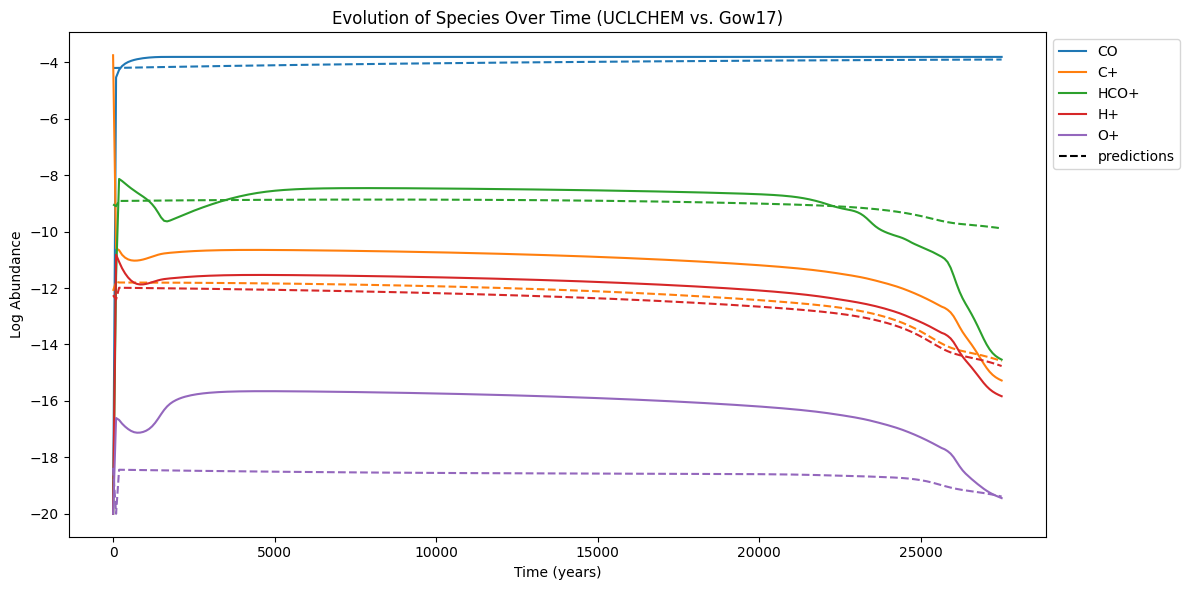

In [6]:
model_of_interest = 5
unique_models = np.unique(validation_np[:, 1])
species_of_interest = ["CO", "C+", "HCO+", "H+", "O+"]

df_model = pd.DataFrame(validation_np[validation_np[:, 1] == unique_models[model_of_interest]], columns=GeneralConfig.metadata + GeneralConfig.physical_parameters + GeneralConfig.species)

z = df_model[GeneralConfig.physical_parameters].to_numpy()
processing.physical_parameter_scaling(z)
df_model[GeneralConfig.physical_parameters] = z

fig, ax = plt.subplots(figsize=(12, 6))

for species in species_of_interest:
    x_log_abundance = np.log10(df_model[species])
    x_log_abundance = np.maximum(x_log_abundance, -20)
    y_log_abundance = np.log10(df_test[species])
    y_log_abundance = np.maximum(y_log_abundance, -20)
    
    line_actual, = ax.plot(df_model['Time'], x_log_abundance, label=species)
    ax.plot(df_model['Time'], y_log_abundance, linestyle='--', color=line_actual.get_color())

dummy_line, = ax.plot([], [], linestyle='--', color='black', label='predictions')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Log Abundance')
ax.set_title('Evolution of Species Over Time (UCLCHEM vs. Gow17)')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()